In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import pickle
import random
import math
import time

import nltk
from nltk.tokenize import sent_tokenize

import re

from tqdm import tqdm

import wandb

import torch.utils.data as data
from torch.utils.data import Dataset

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
LMAX = 50

attentionNetworkBool = 1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Get the data

You have to adpt the path to your computer

The data can be downloaded there https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

In [5]:
file_path = '/home/jpierre/other/sentiment_analyzis/data/data_financial.csv'

d = pd.read_csv(file_path)



In [6]:
d.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [7]:
df = d['Sentence'].values
y = d['Sentiment'].values
print(df[2])

For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


In [8]:
labelDict = {}
labelDict['negative'] = 0
labelDict['neutral'] = 1
labelDict['positive'] = 2

## Exploring data

1) Length of our sentences

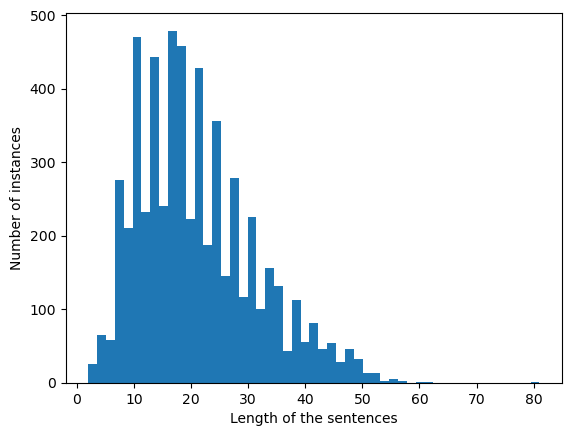

5842


In [9]:
def getLength(data:list, display:bool = True)->list:
    """ 
    Function to get the distribution of the lengths of the sentences in 
    our data
    
    Args:
    -----
    - `data`: list with the sentences
    - `display`(optional): boolean to set the plot of the histogram
    
    Output:
    -------
    the list of lengths
    """
    L = [len(data[i].split(' ')) for i in range(len(data))]

    if display:
        plt.hist(L, bins='auto')
        plt.xlabel('Length of the sentences')
        plt.ylabel('Number of instances')
        plt.savefig('histSentenceLength2.png')
        plt.show()
    return L

L = getLength(df)
print(len(L))

3) Repartition of the labels

In [10]:
def getNb(labelData:list, labelDict:dict = labelDict, display:bool = True)->np.array:
    """
    Function to count the number of instances per label
    
    Args:
    -----
    - `labelData`: list of labels
    - `labelDict`: dictionnary of the labels
    - `display`(optional): boolean to activate the display
    
    Output:
    ------
    - vector wiht counts
    """

    countVect = np.zeros(len(labelDict)).astype(int)

    for i in range(len(labelData)):
        label = labelData[i]
        countVect[labelDict[label]] += 1

    if display:
        plt.bar(list(labelDict.keys()), countVect)
        plt.ylabel('Number of instances')
        plt.savefig('repar2.png')
        plt.show()

    return countVect

{'negative': 0, 'neutral': 1, 'positive': 2}


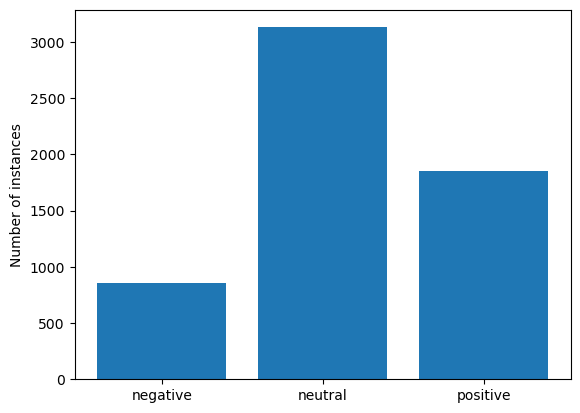

[ 860 3130 1852]


In [11]:
print(labelDict)
nb = getNb(d['Sentiment'])


print(nb)

In order to tackle dataset unbalance, there are different possibilities. The risk is that the network will never predict the majority class as a shortcut. There are multiple solutions

One of them would be to perform data augmentation by rewriting a bit differently the sentences of the class which have less instances (while keeping the sentiment expressed).
However,such technique might be out of the scope of such projects (also generating new sentences). 

In order to tackle this issue, we could instead use an oversampling scheme in order for our data to be less imbalanced.

Yet, we decided to let it that way in order to see if the NN would still be able to learn a bit.

## Preprocessing step

1) contraction (dealing with I'm, I'd, ...)

2) uppercase letters -> lowercase letters

3) get rid of stopwords

4) remove punctiation, numbers

5) dealing with spaces

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
import contractions

stopWords.remove('not')
stopWords.remove('but')
stopWords.remove('i')
stopWords.remove('you')
stopWords.remove('he')
stopWords.remove('she')
stopWords.remove('it')
stopWords.remove('we')
stopWords.remove('they')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess(sentences:list[str], stopWords)->list:
    """
    Function to apply all the preprocessing
    
    Args:
    -----
    - `sentences`: list of sentences
    - `stopWords`: stopwords to handle
    
    Output:
    -------
    the list with the preprocessed sentences
    """
    
    res = []
    for sentence in tqdm(sentences):
        
        ## contractions
        sentence = contractions.fix(sentence)
        
        ## get the sentence in lower case letters
        sentence = sentence.lower()
        
        # websites deletion
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        sentence = re.sub(url_pattern, '', sentence)
        
        ## remove punctuation and numbers (everything that is different from letters)
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        ## remove stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopWords) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        ## take care of spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = sentence.strip()

        res.append(sentence)

    return res


In [14]:
print(df[:15])

["The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."
 '$ESI on lows, down $1.50 to $2.50 BK a real possibility'
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."
 'According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .'
 'The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .'
 "$SPY wouldn't be surprised to see a green close"
 "Shell's $70 Billion BG Deal Meets Shareholder Skepticism"
 'SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimat

In [15]:
df = preprocess(df, stopWords)

100%|██████████| 5842/5842 [00:00<00:00, 16150.15it/s]


In [16]:
print(df[:15])

['geosolutions technology leverage benefon gps solutions providing location based search technology communities platform location relevant multimedia content new powerful commercial model', 'esi lows bk real possibility', 'last quarter componenta net sales doubled eur eur period year earlier it moved zero pre tax profit pre tax loss eur', 'according finnish russian chamber commerce major construction companies finland operating russia', 'swedish buyout firm sold remaining percent stake almost eighteen months taking company public finland', 'spy would not surprised see green close', 'she billion bg deal meets shareholder skepticism', 'ssh communications security corp stock exchange release october pm company updates full year outlook estimates results remain loss full year', 'kone net sales rose year year first nine months', 'stockmann department store total floor space square metres stockmann investment project price tag eur million', 'circulation revenue increased finland sweden', 'sa

### Decompose according to spaces and make a dictionnary for both the learning and the test phase

In [17]:
def decompose(df:list[str])->list:
    """ 
    Function to decompose the sentences according to the spaces
    
    Args:
    -----
    - `df`: list of preprocessed sentences
    
    Output:
    -------
    list with the sentences decomposed according to spaces
    """
    
    for i in tqdm(range(len(df))):
        df[i] = df[i].split(' ')
    return df

df = decompose(df)


100%|██████████| 5842/5842 [00:00<00:00, 605314.33it/s]


In [18]:
print(max([len(df[i]) for i in range(len(df))]))

42


In [19]:
# can update LMAX

LMAX = 50

## Word embeddings

### Word2Vec

In [ ]:
EMB_SIZE =300

In [ ]:
import gensim.downloader as api

word2vecModel = api.load('word2vec-google-news-300')

In [ ]:
def getW2VTextEmb(words:list[str], model = word2vecModel)->torch.tensor:
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    defaultVector = np.ones(EMB_SIZE)
    
    res = []
    for word in words:
        try:
            res.append(torch.from_numpy(model[word]))
        except:
            res.append(torch.from_numpy(defaultVector))
        
    return torch.stack(res)

def sentences2W2VEmbs(sentences:list[str])->torch.tensor:
    """
    Function to apply the word2Vec on sentences
    
    Args:
    -----
    - `sentence`: sentences on which to apply the embeddings

    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getW2VTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2W2VEmbs(sentence)->torch.tensor:
    """
    Function to apply the word2Vec on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getW2VTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

### GloVe

In [20]:
EMB_SIZE =300

In [21]:
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim=EMB_SIZE, unk_init = torch.Tensor.normal_)

In [22]:
def getGloveTextEmb(words, model = glove):
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """

    res = [model[word] for word in words]
    
    return torch.stack(res)

def sentences2GloveEmbs(sentences):
    """
    Function to apply the Glove on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getGloveTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2GloveEmbs(sentence):
    """
    Function to apply the Glove on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getGloveTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

### fasttext

In [20]:
EMB_SIZE = 300

In [21]:
import fasttext
from torchtext.vocab import FastText


fastTextEng = FastText(language='en', unk_init = torch.Tensor.normal_)
            

In [22]:
def getFastTextEmb(words, model = fastTextEng):
    """
    Function to apply the word2Vec on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """

    res = [model[word] for word in words]
    
    return torch.stack(res)

def sentences2FastTextEmbs(sentences):
    """
    Function to apply the FastText on a sentence
    
    Args:
    -----
    - `words`: list of words
    - `model`: model to use
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros((len(sentences), LMAX, EMB_SIZE))
    
    for i in range(len(sentences)):
        sentence = sentences[i]
        
        embs = getFastTextEmb(sentence)  # [l, embs]
        l = embs.shape[0]
        matrix[i, :l, :] = embs
        
    return matrix

def simpleSentences2FastTextEmbs(sentence):
    """
    Function to apply the FastText on sentences
    
    Args:
    -----
    - `sentence`: sentence on which to apply the embeddings
    
    Output:
    -------
    tensor with the embeddings
    """
    matrix = torch.zeros( LMAX, EMB_SIZE)
    
    embs = getFastTextEmb(sentence)  # [l, embs]
    l = embs.shape[0]
    matrix[:l, :] = embs
        
    return matrix

### Global function

In [23]:
EMBTYPE = 'fasttext'

In [24]:
def getEmbedding(sentences, method = EMBTYPE):

    if method == 'Word2Vec':
        embs = simpleSentences2W2VEmbs(sentences)
    
    if method == 'GloVe':
        embs = simpleSentences2GloveEmbs(sentences)

    if method == 'fasttext':
        #embs = sentences2FastTextEmbs(sentences)
        embs = simpleSentences2FastTextEmbs(sentences)
    return embs

## Model

1) simple GRU model

In [25]:
class MLP2(nn.Module):
    def __init__(self, inputShape:int, outputShape:int, dropout:float = 0.3):
        super(MLP2, self).__init__()

        self.dropout = dropout
        self.inputShape = inputShape
        self.outputShape = outputShape

        self.delta = (inputShape - outputShape) // 3
        dim1 = inputShape - self.delta
        dim2 = dim1 - self.delta

        self.mlp = nn.Sequential(
            nn.Linear(inputShape, dim1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim2, outputShape),
        )
    
    def forward(self, x):
        x = self.mlp(x)
        return x

In [26]:
class SimpleGRUClassifier(nn.Module):
    def __init__(self, inputSize, hiddenSize, stateSize, outputSize):
        super(SimpleGRUClassifier, self).__init__()

        self.InMlp = MLP2(inputSize, hiddenSize)       # to bring the embedding to a same dimension

        self.gru = nn.GRU(input_size=hiddenSize, 
                          hidden_size=stateSize, 
                          num_layers=1, 
                          bidirectional=True, 
                          batch_first=True)

        self.outMlp = MLP2(stateSize*2*LMAX, outputSize)  # to bring everything outside of the NN

        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        
        x = self.InMlp(x)
        

        output, _ = self.gru(x)   # [N, L, 2*hiddenSize]
        

        output = self.outMlp(output.reshape(output.shape[0], -1))
                
        return output

In [27]:
class SelfAttention(nn.Module):
    def __init__(self, inputShape:int, outputShape:int):
        """ 
        Args:
        -----
        - `inputShape`: shape of the input
        - `outputShape`: shape of the output (second shape of the value matrix)
        """
        
        super(SelfAttention, self).__init__()
        
        self.inputShape = inputShape
        self.outputShape = outputShape
        
        # matrices for the Q, K, V
        self.W_q = nn.Linear(inputShape, inputShape)
        self.W_k = nn.Linear(inputShape, inputShape)
        self.W_v = nn.Linear(inputShape, outputShape)
        
    def forward(self, x):
        """ 
        Args:
        -----
        - `x`: tensor [N, L, inputShape]
        """
        # Obtainng Q, K, V
        Q = self.W_q(x)   # [N, L, inputShape]
        K = self.W_k(x)   # [N, L, inputShape]
        V = self.W_v(x)   # [N, L, outputShape]
        
        scores = torch.bmm(Q, K.transpose(-2,-1)) / torch.sqrt(torch.tensor(self.inputShape).float())      # [N, L, L]
        
        weights = F.softmax(scores, dim=-1)       # [N, L, L]
        
        out = torch.bmm(weights, V)        # [N, L, outputShape]
        
        return out, weights
    


class AttentionGRUClassifier(nn.Module):
    def __init__(self, inputSize, hiddenSize, stateSize, outputSize):
        super(AttentionGRUClassifier, self).__init__()

        self.InMlp = MLP2(inputSize, hiddenSize)       # to bring the embedding to some given dimension

        self.gru = nn.GRU(input_size=hiddenSize, 
                          hidden_size=stateSize, 
                          num_layers=1, 
                          bidirectional=True, 
                          batch_first=True)
        
        self.attentionLayer = SelfAttention(2*stateSize, 2*stateSize)  #*2 because of the bidirectionnal GRU

        self.outMlp = MLP2(stateSize*2*LMAX, outputSize)  # to bring everything outside of the NN

    def forward(self, x):
                
        x = self.InMlp(x)

        output, _ = self.gru(x)   # [N, L, 2*hiddenSize]
        
        
        output, weights = self.attentionLayer(output)

        output = self.outMlp(output.reshape(output.shape[0], -1))
                
        return output, weights

## Dataset Class

In [28]:
class textDatasets(Dataset):
    """
    Class to generate data tuples for learning
    """

    def __init__(self, langList:list[list[str]], y:list[int]):
        """ 
        Args:
        -----
        - `langList`: list of the sentences
        - `y`: list of labels
        """

        self.langList = langList
        self.y = y
        self.length = len(langList)


    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        
        s = getEmbedding(self.langList[idx])
        y = self.y[idx]
        
        return s, y

In [29]:
L = int(0.7*len(df))
dfTrain = df[:L]
dfTest = df[L:]

y1 = d['Sentiment'].values
y2 = [labelDict[y[i]] for i in range(len(y))]
yTrain = y2[:L]
yTest = y2[L:]

nbBatch = 200

datasetLearning = textDatasets(langList=dfTrain, y = yTrain)
datasetTest = textDatasets(langList=dfTest, y = yTest)

loaderLearning = data.DataLoader(datasetLearning, batch_size = nbBatch, shuffle= True, num_workers = 1)
loaderTest = data.DataLoader(datasetTest, batch_size = nbBatch, shuffle= True, num_workers = 1)


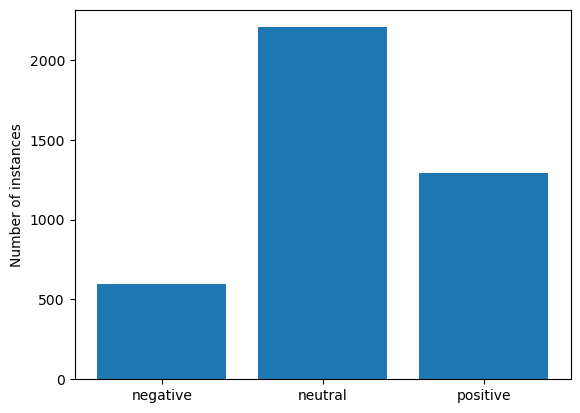

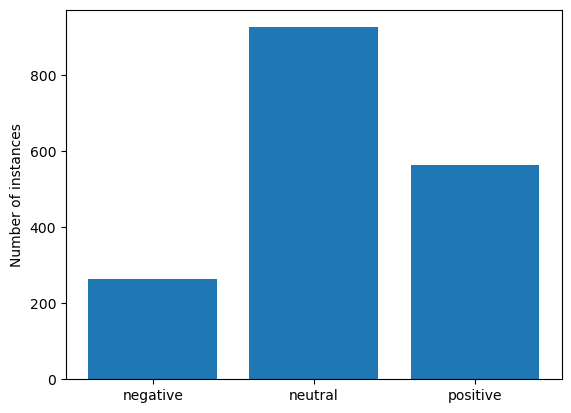

In [30]:
nb = getNb(y1[:L])
nb = getNb(y1[L:])

## Training

In [31]:
inputShape = EMB_SIZE
hiddenShape = 128
hiddenStatesShape = 128
outputShape = len(labelDict)

if attentionNetworkBool:
    NN = AttentionGRUClassifier(inputShape, hiddenShape, hiddenStatesShape, outputShape).to(device)
else:
    NN = SimpleGRUClassifier(inputShape, hiddenShape, hiddenStatesShape, outputShape).to(device)


In [32]:

def getAccuracy(out, gtruth):
    """
    Function to get the accuracy
    
    Args:
    -----
    - `out`: prediction of the neural network
    - `gtruth`: ground truths
    
    Ouptut:
    -------
    number of correctly classified instances
    """
    
    gtruth = gtruth.reshape(-1)
    _, i = out.topk(1, dim=-1)
    i = i.reshape(-1)
    return torch.sum(i == gtruth)


In [33]:
nbEpoch=300
loaderLearning = loaderLearning
loaderValidation = loaderTest
loaderTest = loaderTest
decay = .00001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(NN.parameters(), lr=0.005, weight_decay=5e-4)

/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
wandb.init(project = 'master_thesis', name = "sentiment_ana_fast_financial_attentionB")
wandb.watch(NN, log = 'all', log_freq=500)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jepi1202 (uliege_action_spotting_2022_2023_context). Use `wandb login --relogin` to force relogin


[]

In [35]:
def train():

    j = 0
    max_valid = float('-inf')

    for i in range(nbEpoch):

        NN.train()

        for x, y in tqdm(loaderLearning):
           
            x = x.to(device)
            y = y.to(device)

            if attentionNetworkBool:
                out, _ =  NN(x)
            else:
                out =  NN(x)

            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((j+1) % 5) == 0:
                
                max_param_value = max(torch.max(torch.abs(param)).item() for param in NN.parameters())

                max_grad_value = max(torch.max(torch.abs(param.grad)).item() for param in NN.parameters() if param.grad is not None)
                
                
                wandb.log({'epoch': i, 'Training Loss': loss, 'max param': max_param_value, 'max grad': max_grad_value})
                


            if ((j+1) % 75) == 0:
                NN.eval()
                
                with torch.no_grad():
                    
                    # training accuracy
                    trainAcc = 0
                    for x, y in loaderLearning:
           
                        x = x.to(device)
                        y = y.to(device)

                        if attentionNetworkBool:
                            out, _ =  NN(x)
                        else:
                            out =  NN(x)
                    
                        trainAcc += getAccuracy(out, y)
                        
                    
                    wandb.log({'epoch': i, 'training accuracy': trainAcc / len(datasetLearning)})
                    
                    
                NN.train()
                
                if attentionNetworkBool:
                    torch.save(NN.state_dict(), "mod_fastText_fin_attention_1.pt")
                else:
                    torch.save(NN.state_dict(), "mod_fastText_fin_1.pt")
            j += 1
            
if __name__ == "__main__":

    train()

 81%|████████  | 17/21 [00:04<00:01,  3.86it/s]


KeyboardInterrupt: 

## Analyzing the results

In [ ]:
sd = torch.load('/home/jpierre/other/sentiment_analyzis/mod_fastText_best_c.pt')
NN.load_state_dict(sd)
NN = NN.to(device)
NN.eval()

# next part does not support attention (yet ?), just copy paste stuff from the other notebook ... (requires some conditions)

In [119]:
preds = None
y = None
for x_test, y_test in loaderTest:
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    out =  NN(x_test)
    
    if preds is None:
        preds = out
    else:
        preds = torch.vstack((preds, out))
        
    if y is None:
        y = y_test.reshape(-1)
    else:
        y = torch.concat((y.reshape(-1), y_test.reshape(-1)))


In [120]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('conf_mat.png')
    plt.show()



In [121]:
y = y.cpu().numpy()
_, i = preds.topk(1, dim = -1)
predictions = i.reshape(-1).cpu().numpy()

[[152  83  29]
 [137 691  98]
 [ 46 132 385]]


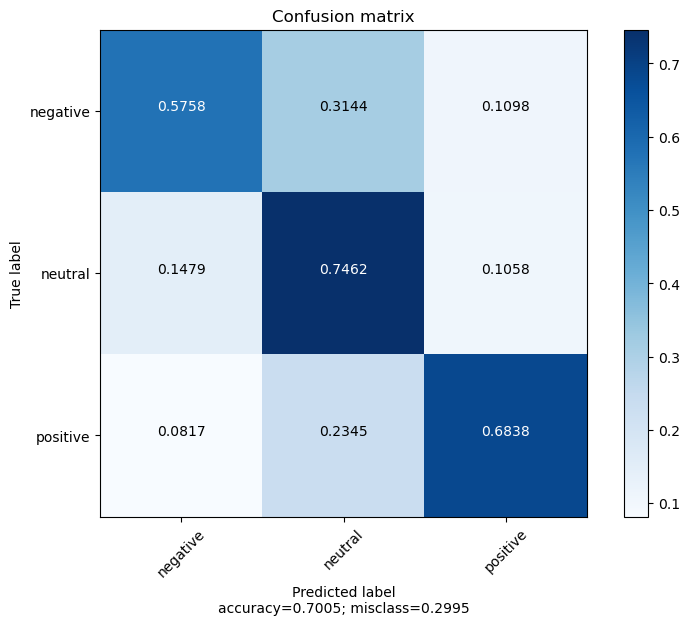

In [122]:
from sklearn.metrics import confusion_matrix
import itertools

conf_matrix = confusion_matrix(y, predictions)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'], normalize=True)